# IWAL + Stopping Criteria

This code is adapted from my HW2, Exercise 2 implementation of IWAL. 

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
#read the data: note there is no header
df = pd.read_csv('/Users/jonathanzhu/Documents/data/vc_mutant_data.csv', header=None)

#rename columns: all are x0, x1, x2, etc. except the last one, which is "Class"
df.columns = ['x' + str(i) for i in range(0, 512)] + ['Class']
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,Class
0,0.052671,-0.170843,0.127665,-0.157065,0.149449,-0.405221,-0.015877,1.019597,0.306551,0.057538,...,1.002674,0.837392,1.133352,-0.255242,0.919627,-0.167685,1.559194,0.124128,0.642259,flaA
1,0.010678,-0.170641,0.137485,-0.158542,0.166123,-0.352311,0.006440,1.031316,0.309140,-0.023432,...,0.972432,0.887417,1.089113,-0.302200,0.849822,-0.190138,1.495022,0.091063,0.695978,flaA
2,0.031659,-0.180831,0.093920,-0.172080,0.157711,-0.415934,-0.031329,1.123129,0.252306,0.008820,...,1.016015,0.926723,1.136414,-0.335968,0.847125,-0.204482,1.524836,0.071172,0.737653,flaA
3,0.075516,-0.196257,0.198255,-0.160592,0.085160,-0.361760,-0.018122,0.951612,0.351116,0.023851,...,0.971781,0.756529,1.104958,-0.238443,0.922150,-0.206724,1.502505,0.139053,0.605317,flaA
4,0.040185,-0.159659,0.070033,-0.151958,0.170973,-0.406942,-0.017921,1.155567,0.306783,-0.005056,...,0.957689,0.918439,1.098478,-0.306227,0.833798,-0.207886,1.530353,0.123505,0.696751,flaA


In [3]:
#items in the "Class" column are currently strings - convert to integers
items = df['Class'].unique()
corresponding_dict = {items[i]: i for i in range(len(items))}

df['Class'] = df['Class'].map(corresponding_dict)
df.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,Class
0,0.052671,-0.170843,0.127665,-0.157065,0.149449,-0.405221,-0.015877,1.019597,0.306551,0.057538,...,1.002674,0.837392,1.133352,-0.255242,0.919627,-0.167685,1.559194,0.124128,0.642259,0
1,0.010678,-0.170641,0.137485,-0.158542,0.166123,-0.352311,0.006440,1.031316,0.309140,-0.023432,...,0.972432,0.887417,1.089113,-0.302200,0.849822,-0.190138,1.495022,0.091063,0.695978,0
2,0.031659,-0.180831,0.093920,-0.172080,0.157711,-0.415934,-0.031329,1.123129,0.252306,0.008820,...,1.016015,0.926723,1.136414,-0.335968,0.847125,-0.204482,1.524836,0.071172,0.737653,0
3,0.075516,-0.196257,0.198255,-0.160592,0.085160,-0.361760,-0.018122,0.951612,0.351116,0.023851,...,0.971781,0.756529,1.104958,-0.238443,0.922150,-0.206724,1.502505,0.139053,0.605317,0
4,0.040185,-0.159659,0.070033,-0.151958,0.170973,-0.406942,-0.017921,1.155567,0.306783,-0.005056,...,0.957689,0.918439,1.098478,-0.306227,0.833798,-0.207886,1.530353,0.123505,0.696751,0


In [4]:
import pickle
#save the classes to a pickle file for later use
with open('vc_classes.pkl', 'wb') as f:
    pickle.dump(corresponding_dict, f)

Critically for this implementation, we will set aside a test set from the beginning that we will not touch. This will evaluate the efficacy of IWAL with our stopping criteria compared to offline learning. 

In [5]:
df_train = df.sample(frac=0.8, random_state=1) #random state is a seed value
df_test = df.drop(df_train.index)

#make sure each set has all the classes
for i in range(len(corresponding_dict)):
    print('Class', i, 'in train:', df_train['Class'].value_counts()[i])
    print('Class', i, 'in test:', df_test['Class'].value_counts()[i])
    assert df_train['Class'].value_counts()[i] > 0
    assert df_test['Class'].value_counts()[i] > 0


Class 0 in train: 122
Class 0 in test: 22
Class 1 in train: 112
Class 1 in test: 32
Class 2 in train: 122
Class 2 in test: 22
Class 3 in train: 112
Class 3 in test: 32
Class 4 in train: 108
Class 4 in test: 36
Class 5 in train: 123
Class 5 in test: 21
Class 6 in train: 113
Class 6 in test: 31
Class 7 in train: 117
Class 7 in test: 27
Class 8 in train: 108
Class 8 in test: 36


For this exercise, we will be implementing the IWAL algorithm specified by Beygelzimer et al. (2009) The pseudocode listed in the paper details the following steps:

Set $S_0 = \emptyset$
For $t$ from 1 until the data stream runs out:
1. Receive $x_t$
2. $p_t = $ rejection-threshold $(x_t, history \{x_i, y_i, p_i, Q_i: 1 \leq i \leq t\})$
3. Flip a coin with prob of 1 as $p_t$. If 1, request $Q_t$ with weight $p_{min}/p_t$
4. Update training to minimize weighted loss. 


In [6]:
from sklearn.tree import DecisionTreeClassifier
#random forest
from sklearn.ensemble import RandomForestClassifier

In [9]:
#subroutine for IWAL: bootstrapping to define the rejection-threshold subroutine
"""BootstrappingIWAL() takes in the following parameters:
- new_ex: a single new example
- x_hist: all previous examples
- y_hist: all previous labels
- model_hist: all previous models (default to None, in the case they are not made)
- b: length of the initial bootstrap sample
- k: number of bootstrap samples/predictors used in the voting
- t: current time step
- p_min: lower bound on rejection threshold
"""
def BootstrappingIWAL(new_ex, data_hist, models, b, k, t, p_min):
    #first check: t < b
    if t <= b:
        p_t = 1
    
    #second check: t = b
    if t == b:
        #train k predictors on the initial sample
        predictors = []

        for i in range(k):
            clf = DecisionTreeClassifier() #Decision Tree is for the bootstrapped predictors
            curr_sample = get_bootstrap_sample(data_hist)
            clf.fit(curr_sample.iloc[:, :-2], curr_sample.iloc[:, -2])
            predictors.append(clf)
    else:
        predictors = models
    
    #third check: t > b
    if t > b:
        #in this case, p_t is equal to p_min + (1 - p_min) 
        #times the maximum of the difference between losses of any two models in the ensemble, for any two predictions

        #to approach this: first, make predictions for each model
        preds = []
        for model in predictors:
            preds.append(model.predict(new_ex.iloc[:, :-1]))
        
        #the preds is a list of lists, where each list is the predictions of a model
        #convert this to a numpy array
        preds = np.array(preds)
        #take negative log for CE-loss
        preds = -np.log(preds + 1e-10)

        #for each column, get the maximum and minimum
        maxes = np.max(preds, axis = 0)
        mins = np.min(preds, axis = 0)
        diffs = maxes - mins

        #get the maximum difference
        max_diff = np.max(diffs)

        #calculate p_t
        p_t = p_min + (1 - p_min) * max_diff

    if p_t > 1:
        p_t = 1
    if p_t < 0:
        p_t = 0
    
    #check if p_t is NaN
    if np.isnan(p_t):
        raise ValueError("p_t is NaN")

    return p_t, predictors

#helper function: get a bootstrapped sample from a dataframe
def get_bootstrap_sample(data):
    bootstrap = data.sample(n = len(data), replace = True)
    return bootstrap

#now time to define the full IWAL algorithm
"""IWAL() takes in the following parameters:
- x: all examples
- y: all labels
- b: length of the initial bootstrap sample
- k: number of bootstrap samples/predictors used in the voting
- p_min: lower bound on rejection threshold
"""
def IWAL(data, b, k, p_min, epsilon = 0.01):
    #initialize empty lists for the histories
    data_hist = pd.DataFrame(columns = data.columns)
    models = []
    
    #furthermore: lists for probabilities and 0/1 for each example being chosen
    p_hist = []
    Q_hist = [] #0/1

    #initialize a list for weights
    c = []

    #initialize a list for loss and accuracy
    losses = []
    accs = []

    #accepted losses: track for stopping criteria
    losses_accepted = []

    #finally, initialize the dataframe to hold the selected examples
    selected = pd.DataFrame(columns = data.columns)
    #shuffle data
    data = data.sample(frac = 1).reset_index(drop = True)

    #iterate through all examples
    for t in range(len(data)):
        print("Iteration ", t)

        #receive x_t
        x_t = data.iloc[t]
        new_point = pd.DataFrame(x_t).T
        
        #get the probability of x_t being chosen, also the models
        p_t, models = BootstrappingIWAL(new_point, data_hist, models, b, k, t, p_min)
        #check if x_t is chosen by flipping a coin with probability p_t
        Q_t = np.random.binomial(1, p_t)
        Q_hist.append(Q_t)
        if Q_t == 1:
            #add x_t to the selected examples if it is chosen
            selected = pd.concat([selected, new_point])

            #add to histories
            data_hist = pd.concat([data_hist, new_point])
            p_hist.append(p_t)
            
            c.append(p_min / p_t)
        #learn an importance-weighted classifier on the selected examples
        h_t, loss, acc = LearnWeightedClassifier(data_hist, c)
        print(loss)
        #print("Iteration ", t, " loss: ", loss, " accuracy: ", acc)
        losses.append(loss)
        accs.append(acc)

        #check for stopping criteria
        #there are three checks we have to make: first, have we accepted b data points?
        if t >= b:
            losses_accepted.append(loss)
            #if we have accepted b data points, we can check the stopping criteria

            #secondly, what was the last time we accepted a data point that was not in the first b?
            if len(losses_accepted) >= 2 and Q_t == 1:
                loss_prev = losses_accepted[-2]
                loss_curr = losses_accepted[-1]
                if stopping_criteria(loss_prev, loss_curr, epsilon):
                    print("Stopping criteria met")
                    break

    return selected, h_t, losses, accs

#helper function: make v folds for cross-validation
def create_folds(data, v = 5):
    #initialize the folds
    folds = []
    
    #get the number of examples
    n = len(data)
    #get the size of each fold
    fold_size = n // v

    #shuffle the data
    data = data.sample(frac = 1).reset_index(drop = True)

    #iterate through the folds
    for i in range(v):
        #get the start and end indices for the fold
        start = i * fold_size
        end = (i + 1) * fold_size

        #get the fold
        fold = data.iloc[start:end]
        folds.append(fold)

    return folds

#NEW: introduction of stopping criteria, based on the importance-weighted loss gradient
def stopping_criteria(loss_prev, loss_curr, epsilon = 0.01):
    #calculate the gradient
    gradient = np.abs(loss_curr - loss_prev)

    #if either loss is NaN, return False
    if np.isnan(loss_prev) or np.isnan(loss_curr):
        return False

    #check if the gradient is less than epsilon
    if gradient < epsilon:
        return True
    else:
        return False

#helper function: given labelled data and a list of weights, learn a classifier that minimizes weighted 0-1 loss
def LearnWeightedClassifier(data, w): 
    #add weights to the data
    #weights are the last column
    data['weights'] = w

    #create folds for cross-validation
    folds = create_folds(data)
    accs = []
    losses = []

    for i in range(len(folds)):
        #get the training and validation sets
        val = folds[i]
        #training is all other folds combined
        train = pd.concat(folds[:i] + folds[i+1:])
        classes = train['Class'].unique()

        #check: the validation set must have >1 example
        if len(val) <= 1:
            return None, np.nan, np.nan

        #initialize the classifier
        clf = RandomForestClassifier(n_estimators = 20, max_depth = 7, random_state = 42)
        #train the weighted classifier
        clf.fit(train.iloc[:, :-2], train['Class'], sample_weight = train['weights'])
        
        #predict on the validation set
        preds = clf.predict(val.iloc[:, :-2])
        probs = clf.predict_proba(val.iloc[:, :-2])
        #calculate the weighted loss
        loss = 0
        n = len(preds)
        for j in range(len(preds)):
            if preds[j] == val['Class'].iloc[j]:
                pred_class = int(preds[j])
                #locate the index of the class
                class_index = np.where(classes == pred_class)[0][0]
                loss += (val['weights'].iloc[j] * -np.log(probs[j][class_index] + 1e-10)) / n

        #sometimes loss will be in an array, like [0.5]
        #in this case, we just want the number
        if type(loss) == np.ndarray:
            loss = loss[0]

        loss /= len(preds)
        #print(loss)
        losses.append(loss)

        #calculate the accuracy
        acc = clf.score(val.iloc[:, :-2], val['Class'])
        accs.append(acc)
    
    #print(np.array(losses))
    #get the average loss and accuracy
    loss_full = np.mean(np.array(losses))
    acc = np.mean(accs)

    return clf, loss_full, acc



In [10]:
#simulate active learning by IWAL 10 times
#with parameters b = 20% of the data, k = 10, p_min = 0.1
accs_iwal = []
losses_iwal = []
selected_all = []
b = 20
k = 10
p_min = 0.1

for i in range(10):
    selected, h_t, losses, accs = IWAL(df_train, b, k, p_min, epsilon = 0.0001)
    accs_iwal.append(accs)
    losses_iwal.append(losses)
    selected_all.append(selected)
    
    print("Simulation", i, "done")

Iteration  0
nan
Iteration  1
nan
Iteration  2
nan
Iteration  3
nan
Iteration  4
nan
Iteration  5
nan
Iteration  6
nan
Iteration  7
nan
Iteration  8
nan
Iteration  9
0.02446426127886603
Iteration  10
0.017532789480766576
Iteration  11
0.25472277057827064
Iteration  12
0.2572768987004339
Iteration  13
0.018971199842192147
Iteration  14
0.17039656721080765
Iteration  15
0.056285413382076675
Iteration  16
0.019971548480582163
Iteration  17
0.07739212991487956
Iteration  18
0.12280453828301577
Iteration  19
0.16178102395614666
Iteration  20
0.1311060506299528
Iteration  21
0.12873465064830378
Iteration  22
0.05527390048016576
Iteration  23
0.1367308127119073
Iteration  24
0.11609836163469764
Iteration  25
0.13202526373093232
Iteration  26
0.15351454968243797
Iteration  27
0.09079901289155703
Iteration  28
0.034695560273492534
Iteration  29
0.10586138475379563
Iteration  30
0.08766417081899797
Iteration  31
0.07254484673095793
Iteration  32
0.07123654867272194
Iteration  33
0.10575279846809

In [11]:
#make all entries in accs_iwal the same length
max_length = max([len(accs) for accs in accs_iwal])
for i in range(len(accs_iwal)):
    print(len(accs_iwal[i]), "vs", max_length)
    if len(accs_iwal[i]) < max_length:
        accs_iwal[i] = np.concatenate((accs_iwal[i], np.full(max_length - len(accs_iwal[i]), np.nan)))
    else:
        accs_iwal[i] = accs_iwal[i][:max_length]

59 vs 229
76 vs 229
229 vs 229
98 vs 229
159 vs 229
126 vs 229
119 vs 229
176 vs 229
43 vs 229
95 vs 229


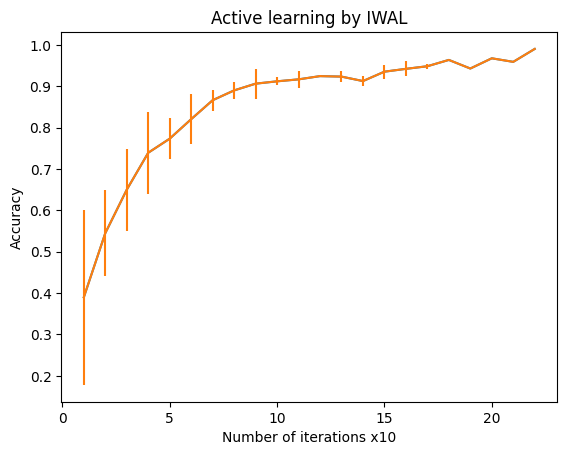

In [12]:
#plot the results
accs_iwal = np.array(accs_iwal)
mean_accs_iwal = np.nanmean(accs_iwal, axis=0)
std_accs_iwal = np.nanstd(accs_iwal, axis=0)

#pick every 10th point
mean_accs_iwal = mean_accs_iwal[::10]
std_accs_iwal = std_accs_iwal[::10]

plt.plot(mean_accs_iwal)
plt.errorbar(range(len(mean_accs_iwal)), mean_accs_iwal, yerr=std_accs_iwal)
plt.xlabel("Number of iterations x10")
plt.ylabel("Accuracy")
plt.title("Active learning by IWAL")
plt.show()

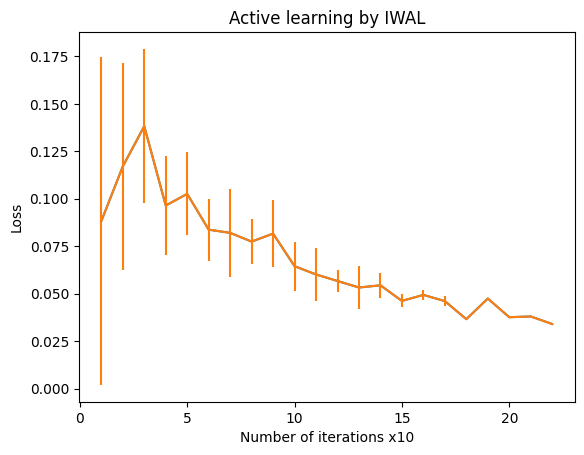

In [13]:
#same as above, but with loss
max_length = max([len(losses) for losses in losses_iwal])
for i in range(len(losses_iwal)):
    if len(losses_iwal[i]) < max_length:
        losses_iwal[i] = np.concatenate((losses_iwal[i], np.full(max_length - len(losses_iwal[i]), np.nan)))
    else:
        losses_iwal[i] = losses_iwal[i][:max_length]

losses_iwal = np.array(losses_iwal)
mean_losses_iwal = np.nanmean(losses_iwal, axis=0)
std_losses_iwal = np.nanstd(losses_iwal, axis=0)

#pick every 10th point
mean_losses_iwal = mean_losses_iwal[::10]
std_losses_iwal = std_losses_iwal[::10]

plt.plot(mean_losses_iwal)
plt.errorbar(range(len(mean_losses_iwal)), mean_losses_iwal, yerr=std_losses_iwal)
plt.xlabel("Number of iterations x10")
plt.ylabel("Loss")
plt.title("Active learning by IWAL")
plt.show()

In [14]:
#check if all classes are present in the selected examples
for s in selected_all:
    classes = s['Class'].unique()
    print("Classes in selected examples: ", classes)
    print("Number of examples: ", len(s))
    #check if all classes are present
    if len(classes) != 9:
        print("Not all classes are present")
    else:
        print("All classes are present")

Classes in selected examples:  [1. 7. 4. 3. 6. 0. 2. 5. 8.]
Number of examples:  59
All classes are present
Classes in selected examples:  [0. 4. 3. 8. 6. 2. 7. 5. 1.]
Number of examples:  74
All classes are present
Classes in selected examples:  [3. 8. 2. 6. 5. 7. 4. 0. 1.]
Number of examples:  214
All classes are present
Classes in selected examples:  [1. 4. 0. 7. 8. 2. 5. 6. 3.]
Number of examples:  95
All classes are present
Classes in selected examples:  [0. 2. 5. 6. 7. 4. 3. 8. 1.]
Number of examples:  155
All classes are present
Classes in selected examples:  [3. 2. 5. 1. 8. 6. 7. 0. 4.]
Number of examples:  118
All classes are present
Classes in selected examples:  [7. 3. 6. 0. 2. 1. 4. 5. 8.]
Number of examples:  117
All classes are present
Classes in selected examples:  [5. 3. 0. 7. 8. 2. 4. 1. 6.]
Number of examples:  162
All classes are present
Classes in selected examples:  [4. 2. 8. 0. 3. 7. 5. 1. 6.]
Number of examples:  43
All classes are present
Classes in selected exa

In [15]:
#for confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

Accuracy:  0.8494208494208494


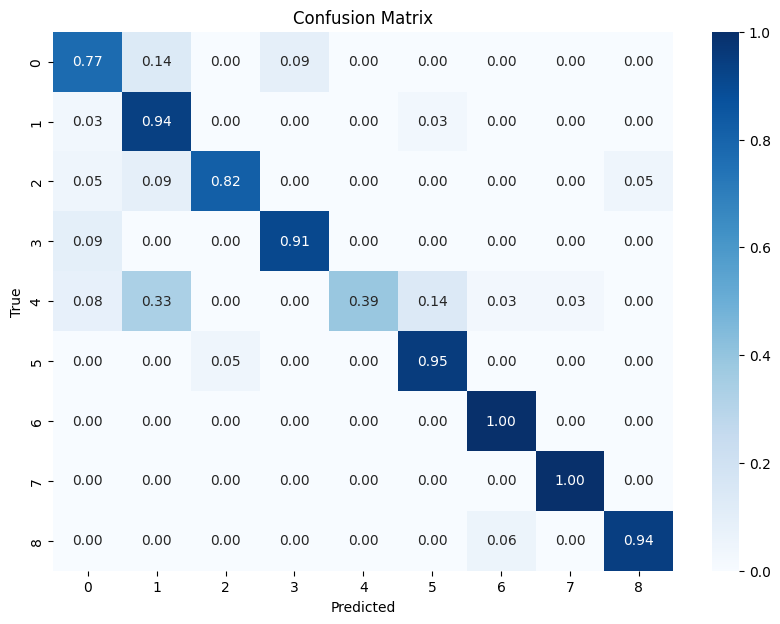

Accuracy:  0.8687258687258688


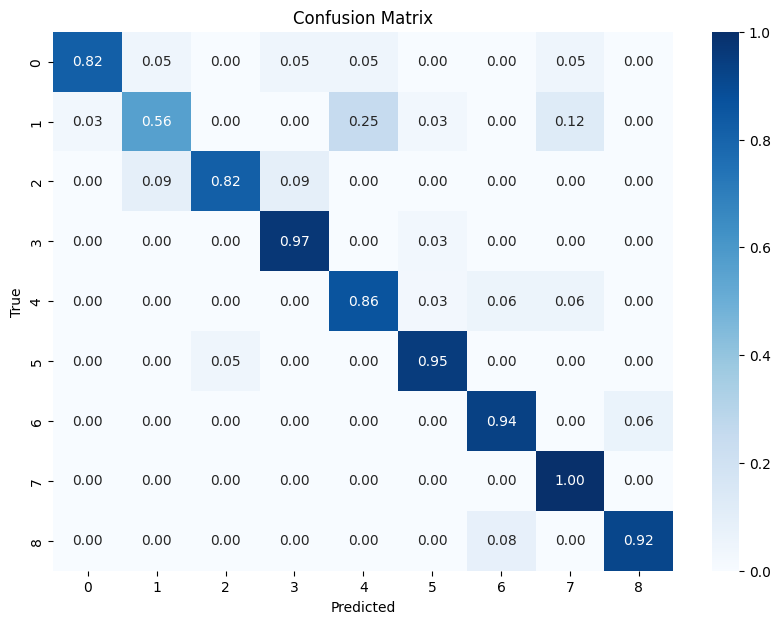

Accuracy:  0.9382239382239382


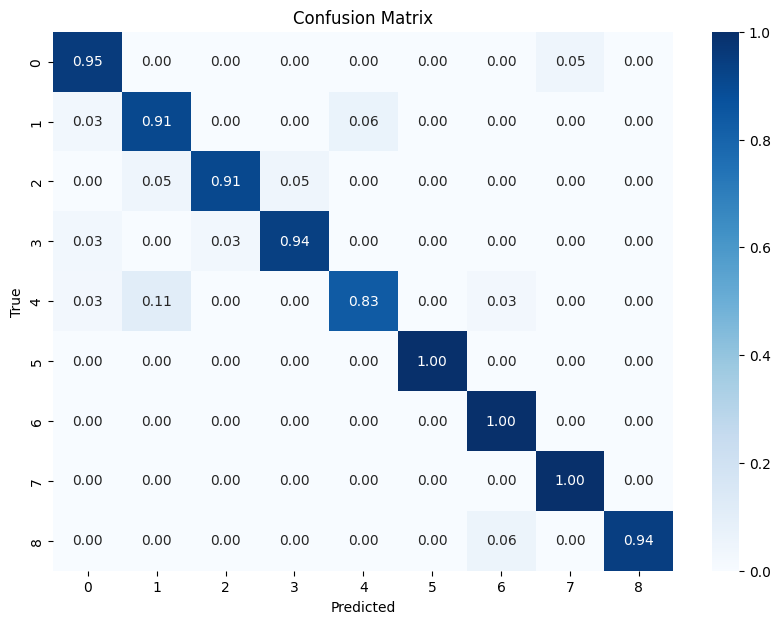

Accuracy:  0.9034749034749034


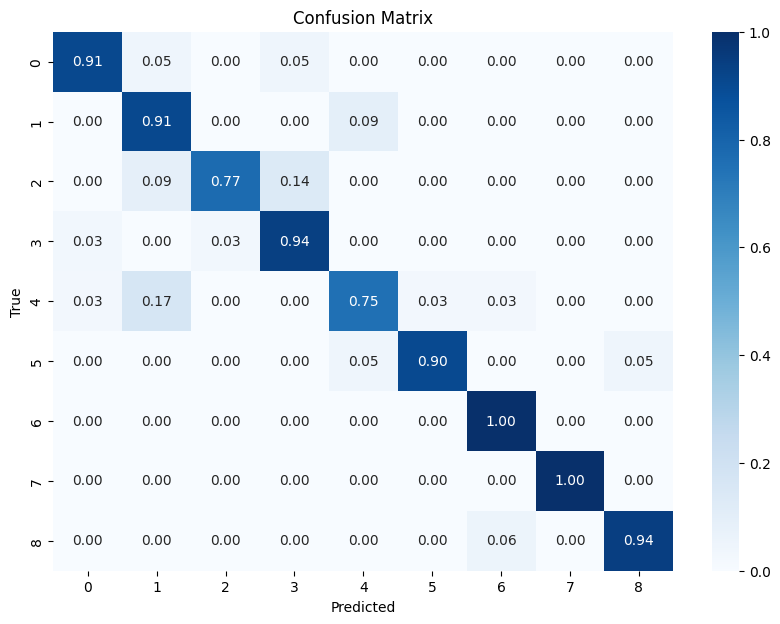

Accuracy:  0.8764478764478765


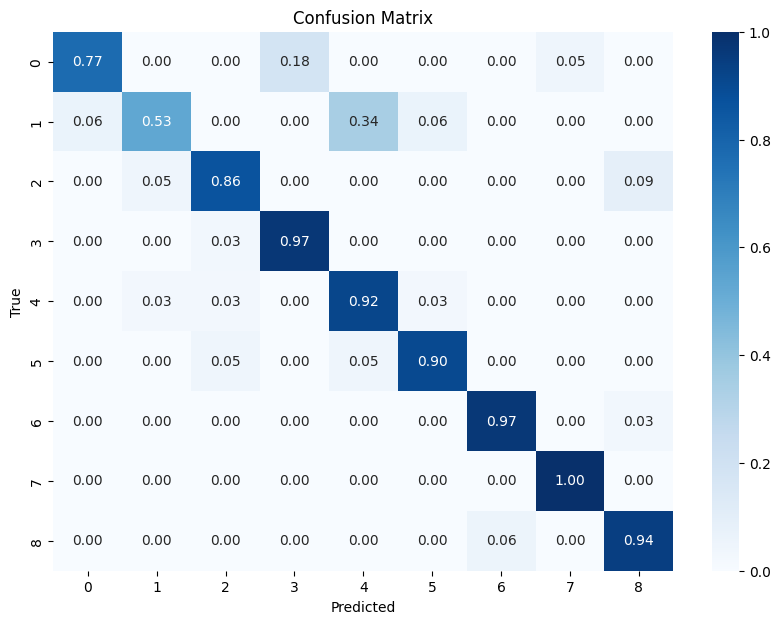

Accuracy:  0.9420849420849421


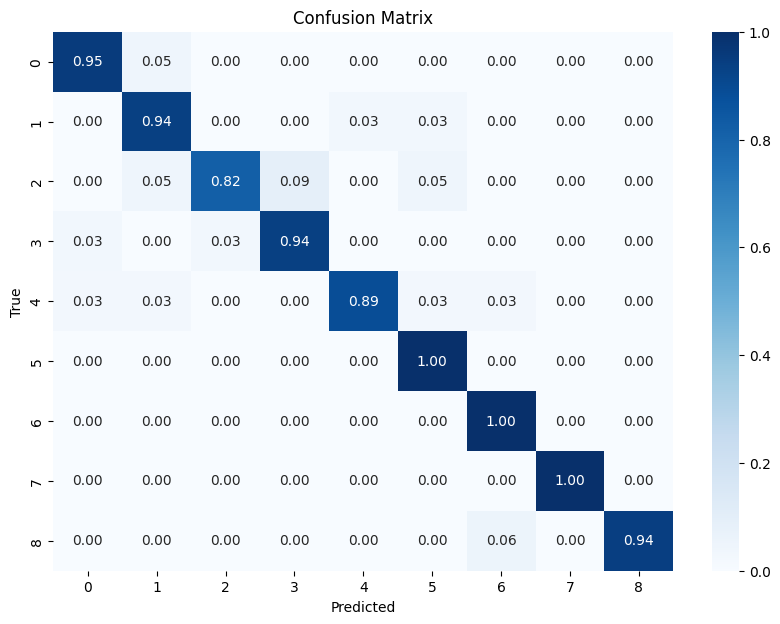

Accuracy:  0.918918918918919


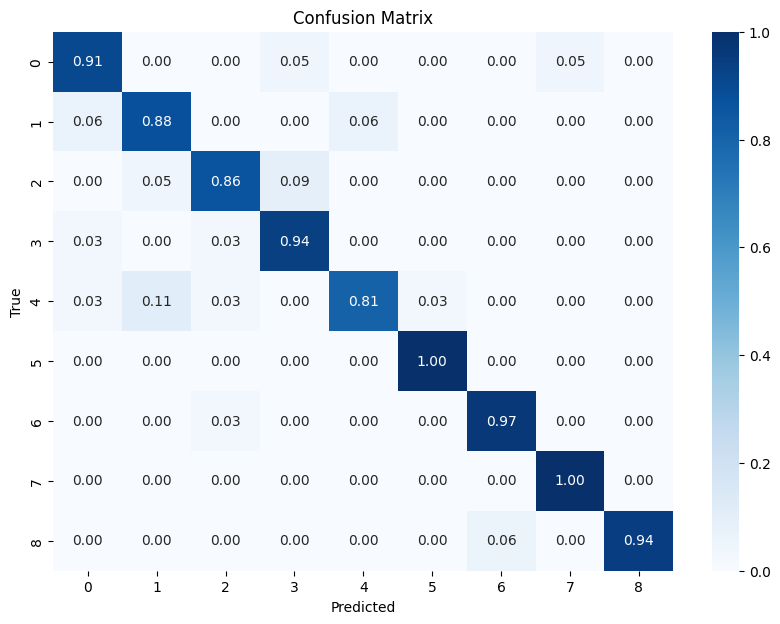

Accuracy:  0.9227799227799228


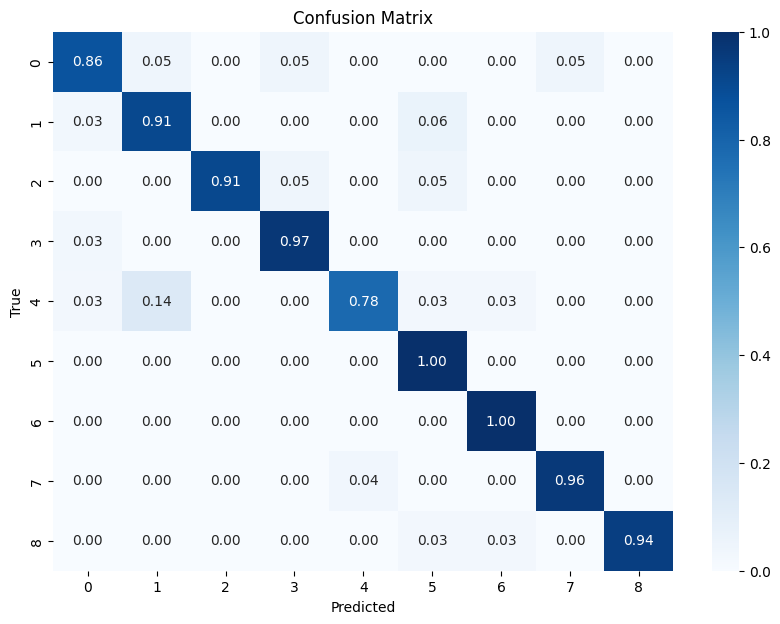

Accuracy:  0.7297297297297297


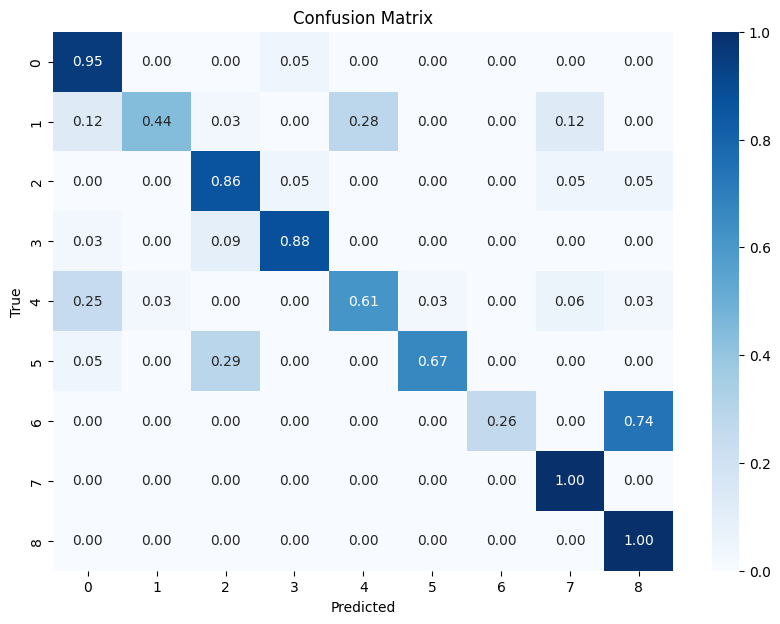

Accuracy:  0.9073359073359073


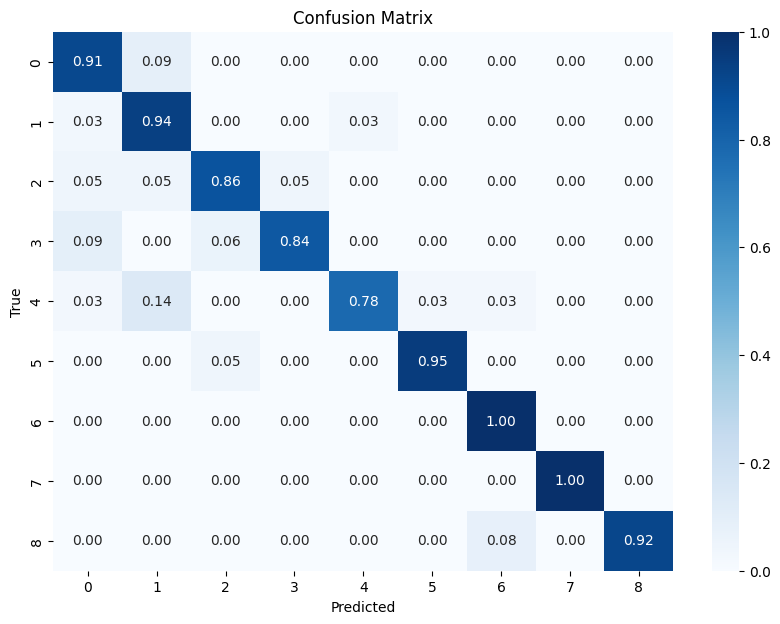

In [16]:
#for each selected dataset, use all the data and train a classifier
accs = []
for s in selected_all:
    #train a classifier on the selected examples
    clf = RandomForestClassifier(n_estimators = 20, max_depth = 7, random_state = 42)
    clf.fit(s.iloc[:, :-2], s['Class'])
    
    #predict on the test set
    preds = clf.predict(df_test.iloc[:, :-2])
    acc = clf.score(df_test.iloc[:, :-2], df_test['Class'])
    accs.append(acc)
    print("Accuracy: ", acc)
    #print confusion matrix
    cm = confusion_matrix(df_test['Class'], preds)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    


Accuracy:  0.9498069498069498


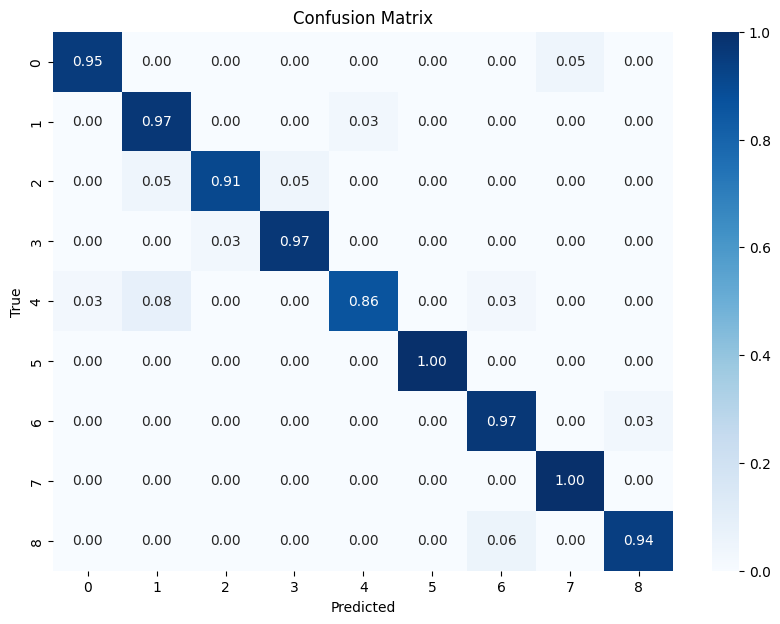

In [17]:
#same as above, but with full df_train
acc_offline = 0

#train a classifier on the full training set
clf = RandomForestClassifier(n_estimators = 20, max_depth = 7, random_state = 42)
clf.fit(df_train.iloc[:, :-2], df_train['Class'])

#predict on the test set
preds = clf.predict(df_test.iloc[:, :-2])
acc_offline = clf.score(df_test.iloc[:, :-2], df_test['Class'])
print("Accuracy: ", acc_offline)

#confusion matrix
cm = confusion_matrix(df_test['Class'], preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

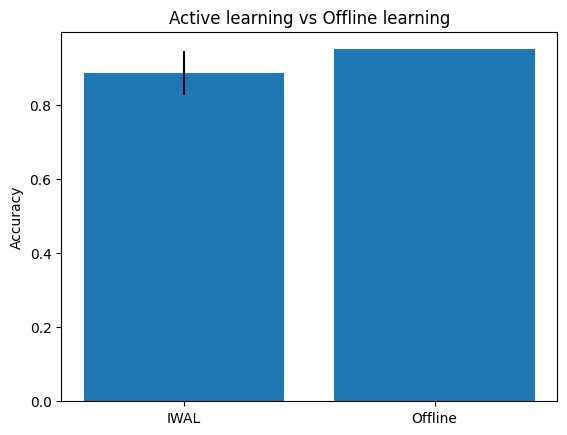

In [18]:
mean_acc_al = np.mean(accs)
std_acc_al = np.std(accs)

#plot above in a bar graph
plt.bar(['IWAL', 'Offline'], [mean_acc_al, acc_offline], yerr=[std_acc_al, 0])
plt.ylabel('Accuracy')
plt.title('Active learning vs Offline learning')
plt.show()
